In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import *

In [2]:
path_to_Gurobi = '/Library/gurobi1003/macos_universal2/bin/gurobi_cl'

### Part a,b -  Minimize number of sensors while covering all pipes

In [3]:
# Parameters

f = pd.read_csv('Detection_Matrix.csv',header = None)   ## Detection Matrix
f.head()

,0,1,2,3,4,5,6,7,8,9,...,801,802,803,804,805,806,807,808,809,810
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,1,0,...,0,1,1,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,1,0,0,0,0,1,...,0,1,1,0,0,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
## Decision Variables

V = [i for i in range(f.shape[1])]
sv = LpVariable.dicts("s", V, 0, cat='Binary')   # Decision to place sensor at node 'v'

In [5]:
# Define problem (objective function)

prob = LpProblem("SensorsAssignment", LpMinimize)
prob += lpSum([sv[v] for v in V])

In [6]:
# Constraints

# Each pipe must have atleast one sensort to detect burst
E = f.shape[0]
for e in range(E):
    prob += lpSum([f.iloc[e,v]*sv[v] for v in V]) >= 1

In [ ]:
# Check solution status
prob.solve(GUROBI_CMD(path=path_to_Gurobi,options=[("MIPGap", 0)]))
print('Solution status: {}'.format(LpStatus[prob.status]))

In [8]:
a_sensors = []
for v in V:
    if sv[v].varValue == 1:
        a_sensors.append(v)
        print(f'Node {v} has a sensor on it.')

Node 16 has a sensor on it.
Node 78 has a sensor on it.
Node 104 has a sensor on it.
Node 206 has a sensor on it.
Node 233 has a sensor on it.
Node 277 has a sensor on it.
Node 392 has a sensor on it.
Node 395 has a sensor on it.
Node 424 has a sensor on it.
Node 426 has a sensor on it.
Node 430 has a sensor on it.
Node 438 has a sensor on it.
Node 454 has a sensor on it.
Node 482 has a sensor on it.
Node 651 has a sensor on it.
Node 705 has a sensor on it.
Node 712 has a sensor on it.
Node 748 has a sensor on it.
Node 786 has a sensor on it.


In [9]:
print(f'Total number of sensors: {prob.objective.value()}')

Total number of sensors: 19.0


### Part c,d - Maximize expected number of pipe bursts detected

In [ ]:
### We want to maximize the expected number of pipe bursts detected for different values of number of available sensors ranging from 0 to 20

obj_vals = []
nodes = {}
B = np.arange(21)
for b in B:

    prob = LpProblem("NetworkMonitor", LpMaximize)

    # Probability of pipe burst
    p=0.1
    
    # DECISION VARIABLES

    # "sv" representing whether sensor is placed at node 'v'
    sv = LpVariable.dicts("s", V, 0, cat='Binary')
    #  "y" representing whether a burst is detected at pipe "e" 
    y = LpVariable.dicts("y", [e for e in range(E)], 0, cat='Binary')

    # OBJECTIVE FUNCTION
    prob += lpSum([y[e]*p for e in range(E)])
    
    # CONSTRAINTS
    # 1. Maximum number of sensors that can be placed is 'b'
    prob += lpSum([sv[v] for v in V]) <= b
    # 2. Pipe burst should not be detected if there are no sensors placed to detect it
    for e in range(E):
        prob += lpSum([f.iloc[e,v]*sv[v] for v in V]) >= y[e]
    
    # SOLVE
    prob.solve(GUROBI_CMD(path=path_to_Gurobi,options=[("MIPGap", 0)]))
    
    # Identify nodes where the sensors are placed   
    sensors = []
    for v in V:
        if sv[v].varValue == 1:
            sensors.append(v)
    nodes[b] = sensors
    obj_vals.append(prob.objective.value()) 

In [11]:
for b in B:
    print(f'The expected number of pipes bursts detected for {b} sensors placed is: {obj_vals[b]}')

The expected number of pipes bursts detected for 0 sensors placed is: 0.0
The expected number of pipes bursts detected for 1 sensors placed is: 39.100000000000286
The expected number of pipes bursts detected for 2 sensors placed is: 58.20000000000056
The expected number of pipes bursts detected for 3 sensors placed is: 74.00000000000007
The expected number of pipes bursts detected for 4 sensors placed is: 83.89999999999951
The expected number of pipes bursts detected for 5 sensors placed is: 90.69999999999912
The expected number of pipes bursts detected for 6 sensors placed is: 96.49999999999879
The expected number of pipes bursts detected for 7 sensors placed is: 99.9999999999986
The expected number of pipes bursts detected for 8 sensors placed is: 103.3999999999984
The expected number of pipes bursts detected for 9 sensors placed is: 105.59999999999827
The expected number of pipes bursts detected for 10 sensors placed is: 107.09999999999819
The expected number of pipes bursts detecte

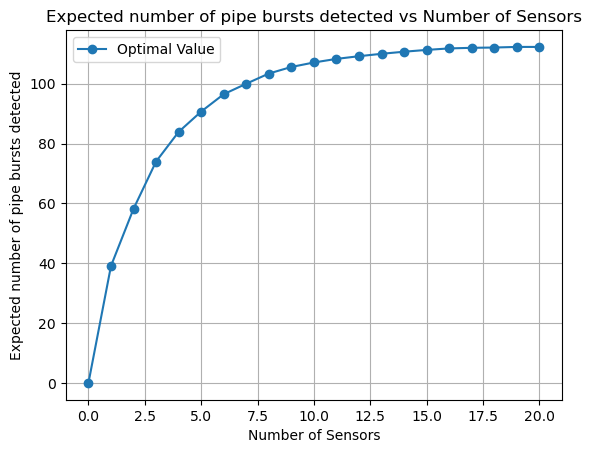

In [12]:
# Plotting

plt.plot(B, obj_vals, label='Optimal Value', marker='o', linestyle='-')
plt.title('Expected number of pipe bursts detected vs Number of Sensors')
plt.xlabel('Number of Sensors')
plt.ylabel('Expected number of pipe bursts detected')
plt.legend()
plt.grid(True)
plt.show()

### Part e - Iterative algorithm to maximize expected number of pipe bursts detected

##### We can use a greedy algorithm to iteratively determine the Top 'b' pipes which cover the most sensors

In [13]:
total_pipe_bursts_detected = []

for b in B:
    f_new = f
    pipe_bursts_detected = 0
    for _ in range(b):
        # Calculate the number of pipes covered by each node
        col_sums = f_new.sum(axis=0)
        
        # Find the node covering the most pipes
        max_col_index = col_sums.idxmax()
        
        # Drop the pipes already covered from the node identified
        f_new = f_new[f_new[max_col_index] != 1]
        # Drop the data related to the node identified to identify the next best node
        f_new = f_new.drop(columns = [max_col_index])
    
    pipe_bursts_detected = f.shape[0] - f_new.shape[0]
    total_pipe_bursts_detected.append(pipe_bursts_detected)

In [14]:
for b in B:
    print(f'The expected pipe bursts detected for {b} sensors are {total_pipe_bursts_detected[b]}')

The expected pipe bursts detected for 0 sensors are 0
The expected pipe bursts detected for 1 sensors are 391
The expected pipe bursts detected for 2 sensors are 562
The expected pipe bursts detected for 3 sensors are 729
The expected pipe bursts detected for 4 sensors are 805
The expected pipe bursts detected for 5 sensors are 864
The expected pipe bursts detected for 6 sensors are 918
The expected pipe bursts detected for 7 sensors are 960
The expected pipe bursts detected for 8 sensors are 994
The expected pipe bursts detected for 9 sensors are 1019
The expected pipe bursts detected for 10 sensors are 1038
The expected pipe bursts detected for 11 sensors are 1055
The expected pipe bursts detected for 12 sensors are 1068
The expected pipe bursts detected for 13 sensors are 1080
The expected pipe bursts detected for 14 sensors are 1088
The expected pipe bursts detected for 15 sensors are 1095
The expected pipe bursts detected for 16 sensors are 1101
The expected pipe bursts detected f

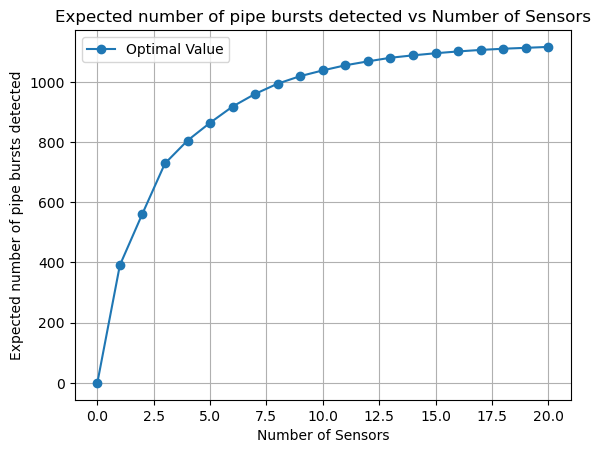

In [15]:
# Plotting

plt.plot(B, total_pipe_bursts_detected, label='Optimal Value', marker='o', linestyle='-')
plt.title('Expected number of pipe bursts detected vs Number of Sensors')
plt.xlabel('Number of Sensors')
plt.ylabel('Expected number of pipe bursts detected')
plt.legend()
plt.grid(True)
plt.show()

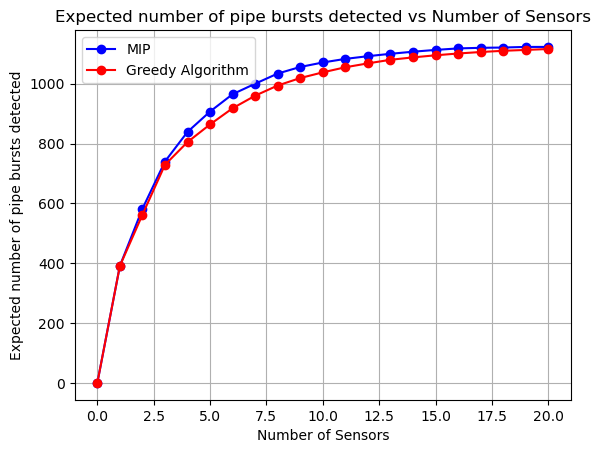

In [21]:
# Plotting Comparison

plt.plot(B, [ov*10 for ov in obj_vals], label='MIP', marker='o', linestyle='-', color='b')
plt.plot(B, total_pipe_bursts_detected, label='Greedy Algorithm', marker='o', linestyle='-', color='r')
plt.title('Expected number of pipe bursts detected vs Number of Sensors')
plt.xlabel('Number of Sensors')
plt.ylabel('Expected number of pipe bursts detected')
plt.legend()
plt.grid(True)
plt.show()

### Part f,g - Minimize highest criticality of a pipe that is not detected

In [22]:
# Parameters - criticality matrix

w = pd.read_csv("Criticality.csv", header=None)
w = w[0].values
w

array([0.12, 0.41, 0.02, ..., 0.74, 0.94, 0.97])

In [ ]:
obj_vals = []
nodes = {}

for b in B:
    # Problem
    prob = LpProblem("NetworkMonitor", LpMinimize)
    
    # DECISION VARIABLES

    # sensor 's' is placed at node 'v' or not
    sv = LpVariable.dicts("s", V, 0, cat='Binary')
    # Burst at pipe 'e' is detected or not
    y = LpVariable.dicts("y", [e for e in range(E)], 0, cat='Binary')
    # 'z' represents the highest criticality score for all the pipes where burst is not detected
    z = LpVariable("z", lowBound = 0, cat='Continuous')

    # OBJECTIVE FUNCTION
    prob += z
    
    # CONSTRAINTS

    #  1. Maximum number of sensors that can be placed is 'b'
    prob += lpSum([sv[v] for v in V]) <= b

    # 2. The value of 'z' should be greater than or equal to all the criticality scores for all the pipes where burst is not detected
    # 3. Pipe burst should not be detected if there are no sensors placed to detect it
    for e in range(E):
        prob += z >= (1-y[e])*w[e]
        prob +=  lpSum([f.iloc[e,v]*sv[v] for v in V]) >= y[e]
    
    # Solve
    prob.solve(GUROBI_CMD(path=path_to_Gurobi,options=[("MIPGap", 0)]))
    
    # Identify nodes where the sensors are placed
    sensors = []
    for v in V:
        if sv[v].varValue == 1:
            sensors.append(v)
    nodes[b] = sensors
    obj_vals.append(prob.objective.value())

In [24]:
for b in B:
    print(f'The minimum highest criticality for {b} sensors placed is: {obj_vals[b]}')

The minimum highest criticality for 0 sensors placed is: 1.0
The minimum highest criticality for 1 sensors placed is: 1.0
The minimum highest criticality for 2 sensors placed is: 1.0
The minimum highest criticality for 3 sensors placed is: 1.0
The minimum highest criticality for 4 sensors placed is: 0.9899999999999999
The minimum highest criticality for 5 sensors placed is: 0.99
The minimum highest criticality for 6 sensors placed is: 0.97
The minimum highest criticality for 7 sensors placed is: 0.96
The minimum highest criticality for 8 sensors placed is: 0.9499999999999998
The minimum highest criticality for 9 sensors placed is: 0.9299999999999998
The minimum highest criticality for 10 sensors placed is: 0.93
The minimum highest criticality for 11 sensors placed is: 0.82
The minimum highest criticality for 12 sensors placed is: 0.81
The minimum highest criticality for 13 sensors placed is: 0.78
The minimum highest criticality for 14 sensors placed is: 0.78
The minimum highest critica

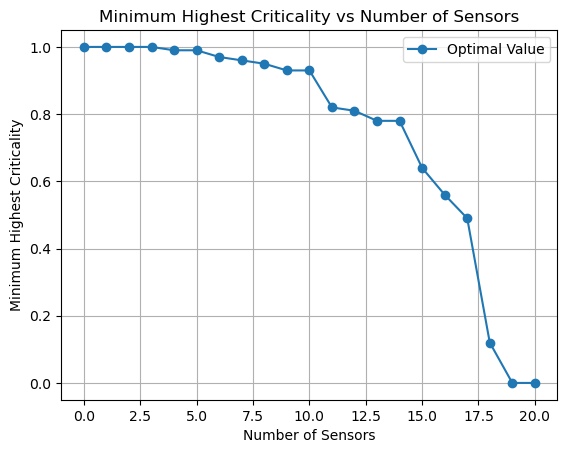

In [25]:
# Plotting
plt.plot(B, obj_vals, label='Optimal Value', marker='o', linestyle='-')
plt.title('Minimum Highest Criticality vs Number of Sensors')
plt.xlabel('Number of Sensors')
plt.ylabel('Minimum Highest Criticality')
plt.legend()
plt.grid(True)
plt.show()